In [1]:
import os
import sys
src_path = sys.path[0].replace("figures", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from profile_extraction import ProfileExtraction
from data_loader import UCSD_dataloader
from utils.plot_utils import *
customize_plt() # customize plt configs, see plot_utils

exp_suffix = "Mar2023"
exp_folder = os.path.join(out_path, "experiments", exp_suffix)
assert os.path.exists(exp_folder)

g:\Anaconda\Anaconda3\envs\base38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def df_filter(df, **kw):
    sig = None
    for k in kw.keys():
        if sig is None:
            sig = df[k] == kw[k]
        else:
            sig = sig & (df[k] == kw[k])
    return df.loc[sig]


def read_df(fn, **kw):
    df = pd.read_excel(fn, index_col=0)
    return df_filter(df, **kw).copy()
    
    
def get_identifier(df, cols):
    def lambda_id(x):
        s = ""
        for c in cols:
            s += f"_{c}-{x[c]}"
        return s[1:]
    return df.apply(lambda_id, axis=1)

In [9]:
log_rep_base_fn = os.path.join(exp_folder, "EnS_base_log.xlsx")
log_rep_base = read_df(log_rep_base_fn, status="D", IS_exponent="None")

log_rep_seed_fn = os.path.join(exp_folder, "EnS_seeds_log.xlsx")
log_rep_seed = read_df(log_rep_seed_fn, status="D", IS_exponent="None")

log_rep = pd.concat([log_rep_base, log_rep_seed], ignore_index=True)
log_rep.index = get_identifier(log_rep, ["alg", "K", "dist_metric", "random_seed"])
log_rep = log_rep.loc[~log_rep.index.duplicated(keep="first")]
log_rep.reset_index(drop=True, inplace=True)

ref_X = log_rep.loc[log_rep["alg"]=="X"]

In [10]:
algs = ["cluster", "unif", "imp"]

alg_colors = {
    "cluster": "dodgerblue",
    "unif": "darkorchid",
    "imp": "seagreen",
}

alg_names = {
    "cluster": "K-Means",
    "unif": "unif. sample",
    "imp": "imp. sample"
}

group_filter = {
    "cluster": {"alg": "cluster"},
    "unif": {"alg": "sample", "dist_metric":"None"},
    "imp": {"alg": "sample", "dist_metric":"l2_center"},
}

grouped_data = {k: {} for k in ["cluster", "unif", "imp"]}

for a in algs:
    data = df_filter(log_rep, **group_filter[a])
    for name, group in data.groupby(by="K"):
        grouped_data[a][name] = group

In [5]:
def draw_stats_seed(res_dict, alg, var, ref=1, ax=None):
    res = []
    for k, v in res_dict[alg].items():
        mu = v[var].mean()
        pct25, pct75 = np.percentile(v[var], [25,75])
        res.append([k, mu, pct25, pct75])
    res = np.array(res).T
    res[1:] /= ref

    if ax is None:
        ax = plt.gca()
    ax.plot(res[0], res[1], ".-", c=alg_colors[alg], label=alg_names[alg])
    # plt.fill_between(res[0], res[2], res[3], alpha=0.3)

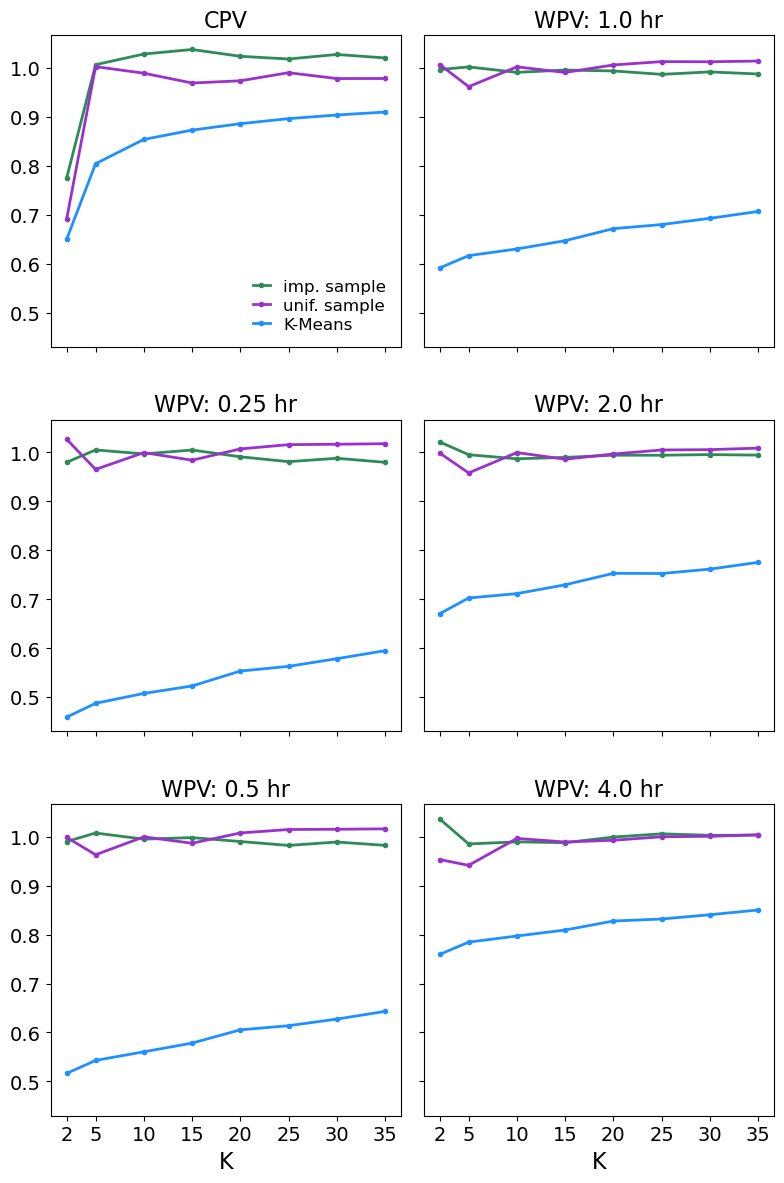

In [342]:
fig, axs = plt.subplots(3, 2, figsize=(8,12), sharey=True)
vars = ["CPV", "WPV_1_mu", "WPV_2_mu", "WPV_4_mu", "WPV_8_mu", "WPV_16_mu"]
for i in range(6):
    ax = axs[i%3, i//3]
    var = vars[i]
    ref = ref_X[var].values[0]
    draw_stats_seed(grouped_data, "imp", var, ref=ref, ax=ax)
    draw_stats_seed(grouped_data, "unif", var, ref=ref, ax=ax)
    draw_stats_seed(grouped_data, "cluster", var, ref=ref, ax=ax)
    ax.set_xticks([2,5,10,15,20,25,30,35])
    ax.set_yticks(np.arange(0.5, 1.05, 0.1))
    if i%3 != 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("K")
    
    if var == "CPV":
        title = var
    else:
        D = var[4:][:-3]
        title = f"WPV: {int(D)/4} hr"
    ax.set_title(title)

    if i == 0:
        ax.legend(loc="lower right")

plt.tight_layout(h_pad=2.5)

# plt.savefig("358-fig4-Z_stats.png", dpi=300, facecolor="w", bbox_inches="tight")

In [6]:
log_365_fn = "LOG-Size_TCO_365.xlsx"
log_365 = pd.read_excel(os.path.join(exp_folder, log_365_fn), index_col=0)
log_365 = log_365.loc[log_365["status"] == "D"]     # only keep finished experiments

log_365_rf = df_filter(log_365, strategy="optimal", deg_model_opt="rainflow", days=365)
log_365_rf = log_365_rf.loc[:,["eq_bat_capacity", "TCO", "TCO_rep", "eq_rate"]].sort_values("eq_bat_capacity")

In [7]:
def draw_size_seed(res_dict, alg, var, lo, H=0.3, ax=None):
    res = []

    ax = plt.gca() if ax is None else ax
    color = alg_colors[alg]

    y_lo, y_hi = ax.get_ylim()


    num_K = len(res_dict[alg])

    y_0 = y_lo + lo * (y_hi-y_lo)
    dy = H * (y_hi - y_lo) / (num_K+1)

    for k, v in grouped_data[alg].items():
        mu = v[var].mean()
        pct25, pct75 = np.percentile(v[var], [25,75])
        res.append([k, mu, pct25, pct75])

        ax.scatter(mu, y_0, s=20, c=color)
        ax.plot([pct25,pct75], [y_0, y_0], c=color, alpha=0.5)
        ax.text(8.2, y_0, k, ha="left", va="center", color=color, fontsize=10)
        y_0 += dy

    ax.text(5.8, y_0-num_K*dy, alg_names[alg], rotation=90, ha="right", va="bottom", color=alg_colors[alg], fontsize=14)

    res = np.array(res).T

Text(0, 0.5, 'eq. elec. rate ($/kWh)')

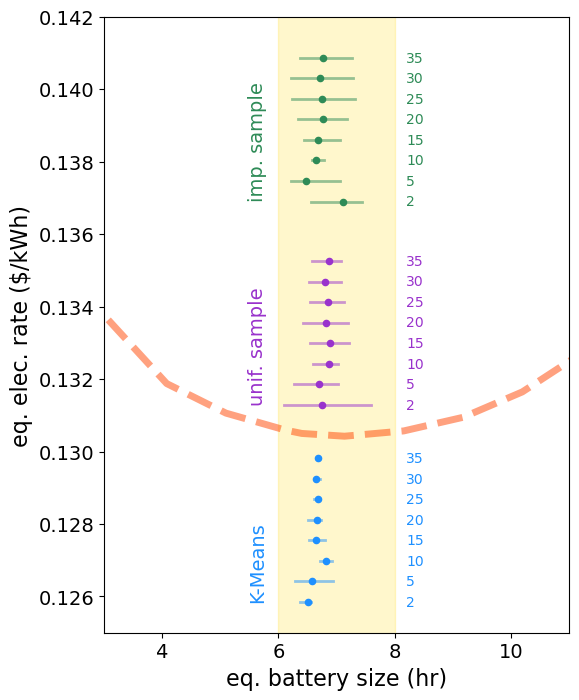

In [12]:
fig, ax = plt.subplots(figsize=(6,8))

var = "eq_bat_capacity"

ax.set_xlim(3, 11)
plt.ylim(0.125, 0.142)


plt.plot(log_365_rf["eq_bat_capacity"], log_365_rf["eq_rate"], "--", c="orangered", lw=5, alpha=0.5)


draw_size_seed(grouped_data, alg="cluster", var=var, lo=0.05, H=0.3)

draw_size_seed(grouped_data, alg="unif", var=var, lo=0.37, H=0.3)

draw_size_seed(grouped_data, alg="imp", var=var, lo=0.7, H=0.3)

ax.fill_between([6,8], [0,0], [1,1], color="gold", zorder=-100, alpha=0.2)

ax.set_xlabel("eq. battery size (hr)")
ax.set_ylabel("eq. elec. rate ($/kWh)")

# plt.savefig("358-fig5-sizing.png", dpi=300, facecolor="w", bbox_inches="tight")